# Questions per context
This script computes statistics for how many questions are asked for each context. The instruction to the annotators were just to ask questions on the given contexts, thus, each context could have any number of questions related to it.

In [13]:
# Load necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import itertools

In [14]:
df_train = pd.read_pickle("../data_frames/parsed_answer_data/df_train_cleaned.pkl")


In [21]:
def plot_question_distribution(data):
    plt.hist(data.values(), density=True, bins=10, color='g')
    plt.ylabel('%')
    plt.xlabel('Number of questions for context')
    plt.title('Number of question per context')
    plt.show()

def plot_question_coubnt_vs_length(c_count_dict, c_length_dict):
    c_count = []
    c_length = []
    for key, val in c_count_dict.items():
        c_count.append(val)
        c_length.append(c_length_dict[key])
    # sort the two lists in ascending
    c_length, c_count = zip(*sorted(zip(c_length, c_count)))
    plt.plot(c_length, c_count, color='g')
    plt.xlim(100, 1000)
    plt.ylabel('number of questions')
    plt.xlabel('Context text length')
    plt.title('Context text length vs num questions')
    plt.show()


Num contexts:  498


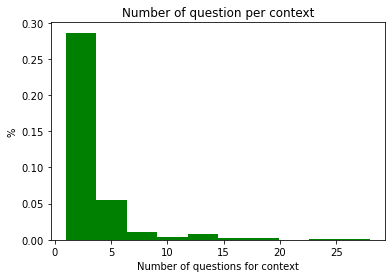

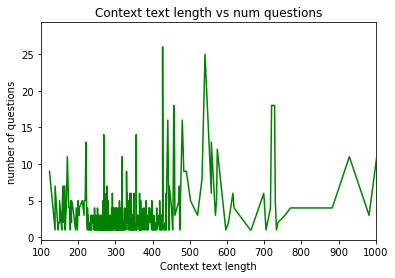

In [22]:
def count_questions_per_answers(df):
    context_count_dict = {}
    context_length_dict = {}
    for index, row in df.iterrows():
        context = row['context']
        context_parsed = row['context_raw']
        c = list(itertools.chain.from_iterable(context_parsed))
        #  print(c)
        if context in context_count_dict:
            context_count_dict[context] += 1
        else:
            context_length_dict[context] = len(c)
            context_count_dict[context] = 1
    print('Num contexts: ', len(context_count_dict))
    return context_count_dict, context_length_dict

c_count_dict, c_length_dict = count_questions_per_answers(df_train)
plot_question_distribution(c_count_dict)
plot_question_coubnt_vs_length(c_count_dict, c_length_dict)